# Preparación del entorno

In [1]:
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Rutas
DATASET_DIR = Path("dataset_cls")
TRAIN_DIR = DATASET_DIR / "train"
VAL_DIR   = DATASET_DIR / "val"
TEST_DIR  = DATASET_DIR / "test"

assert TRAIN_DIR.exists() and VAL_DIR.exists() and TEST_DIR.exists(), "Revisa rutas train/val/test"

# Clases
CLASSES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
print("Clases:", CLASSES)

# Modelo base (clasificación)
BASE_MODEL = "yolo11s-cls.pt"

Clases: ['defecto', 'no_defecto']


# Predecir carpeta + sacar DF

In [2]:
def predict_folder_to_df(model: YOLO, folder: Path, classes: list[str], imgsz: int = 224):
    image_paths = [p for p in folder.rglob("*") if p.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".tif",".tiff"]]
    rows = []
    for img_path in image_paths:
        r = model.predict(img_path, imgsz=imgsz, verbose=False)[0]
        pred_id = int(r.probs.top1)
        conf = float(r.probs.top1conf)
        pred_name = r.names[pred_id]
        true_name = img_path.parent.name  # nombre carpeta = etiqueta real

        rows.append({
            "image_path": str(img_path),
            "image": img_path.name,
            "true_class": true_name,
            "pred_class": pred_name,
            "confidence": conf
        })
    return pd.DataFrame(rows)

# Métricas poniendo el foco en el defecto

In [3]:
def compute_metrics_binary(df_pred: pd.DataFrame, positive_class: str = "defecto"):
    y_true = df_pred["true_class"].tolist()
    y_pred = df_pred["pred_class"].tolist()

    acc = accuracy_score(y_true, y_pred)

    # Para binario, calculamos precision/recall/f1 para la clase positiva
    report = classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division=0)
    pos = report.get(positive_class, {"precision":0, "recall":0, "f1-score":0})

    return {
        "accuracy": acc,
        f"precision_{positive_class}": pos["precision"],
        f"recall_{positive_class}": pos["recall"],
        f"f1_{positive_class}": pos["f1-score"],
        "report_dict": report
    }

# Entrenar 1 experimento (“final” de prueba)

In [9]:
RUN_NAME = "final_train"

model = YOLO(BASE_MODEL)
train_res = model.train(
    data=str(DATASET_DIR),
    epochs=50,
    imgsz=224,
    batch=32,
    patience=10,
    optimizer="Adam",
    lr0=1e-3,
    project="runs_cls",
    name=RUN_NAME,
    verbose=True
)

BEST_PT = Path(train_res.save_dir) / "weights" / "best.pt"
print("Best model:", BEST_PT)

Ultralytics 8.3.252  Python-3.13.5 torch-2.9.1+cpu CPU (Intel Core(TM) Ultra 7 165H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=final_train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, 

# Evaluación en TEST (con matriz de confusión + CSV)

,image_path,image,true_class,pred_class,confidence
0,dataset_cls\test\defecto\kos02_Part6.jpg,kos02_Part6.jpg,defecto,defecto,0.989065
1,dataset_cls\test\defecto\kos08_Part2.jpg,kos08_Part2.jpg,defecto,no_defecto,0.999967
2,dataset_cls\test\defecto\kos09_Part6.jpg,kos09_Part6.jpg,defecto,defecto,1.000000
3,dataset_cls\test\defecto\kos15_Part3.jpg,kos15_Part3.jpg,defecto,no_defecto,0.962998
4,dataset_cls\test\defecto\kos16_Part5.jpg,kos16_Part5.jpg,defecto,defecto,1.000000


CSV guardado: predicciones_test.csv
Accuracy test: 0.9683
Recall defecto: 0.7778
F1 defecto: 0.8750

=== Classification Report ===
              precision    recall  f1-score   support

     defecto     1.0000    0.7778    0.8750         9
  no_defecto     0.9643    1.0000    0.9818        54

    accuracy                         0.9683        63
   macro avg     0.9821    0.8889    0.9284        63
weighted avg     0.9694    0.9683    0.9666        63



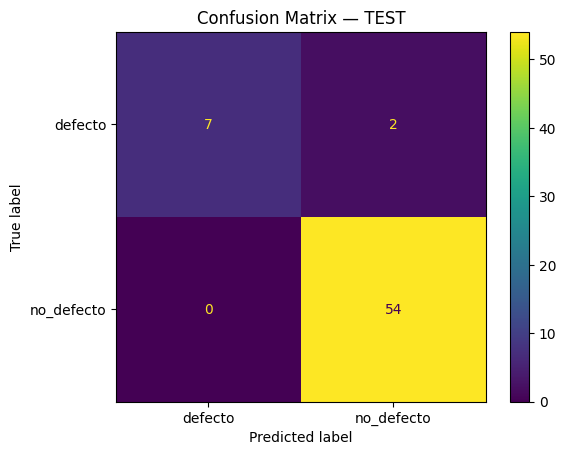

In [10]:
model_best = YOLO(str(BEST_PT))

df_test = predict_folder_to_df(model_best, TEST_DIR, CLASSES, imgsz=224)
display(df_test.head())

df_test.to_csv("predicciones_test.csv", index=False)
print("CSV guardado: predicciones_test.csv")

# Métricas
m = compute_metrics_binary(df_test, positive_class="defecto")
print(f"Accuracy test: {m['accuracy']:.4f}")
print(f"Recall defecto: {m['recall_defecto']:.4f}")
print(f"F1 defecto: {m['f1_defecto']:.4f}")

# Report
print("\n=== Classification Report ===")
print(classification_report(df_test["true_class"], df_test["pred_class"], digits=4, zero_division=0))

# Matriz de confusión
labels = CLASSES
cm = confusion_matrix(df_test["true_class"], df_test["pred_class"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.title("Confusion Matrix — TEST")
plt.show()

# Errores más graves (alta confianza pero mal)

In [11]:
df_errors = df_test[df_test["true_class"] != df_test["pred_class"]].copy()
df_errors = df_errors.sort_values("confidence", ascending=False)

print("Errores:", len(df_errors))
display(df_errors.head(15))

Errores: 2


,image_path,image,true_class,pred_class,confidence
1,dataset_cls\test\defecto\kos08_Part2.jpg,kos08_Part2.jpg,defecto,no_defecto,0.999967
3,dataset_cls\test\defecto\kos15_Part3.jpg,kos15_Part3.jpg,defecto,no_defecto,0.962998


# Grid-search (guardar CSV + eligir el mejor)

In [4]:
import itertools
from pathlib import Path
import pandas as pd

GRID = {
    "imgsz": [224],
    "batch": [16, 32],
    "lr0": [1e-3, 5e-4],
    "epochs": [100],
    "optimizer": ["Adam"],
    "patience": [10],         # early stopping
}

SELECT_BY = "recall_defecto"

experiments = list(itertools.product(
    GRID["imgsz"], GRID["batch"], GRID["lr0"], GRID["epochs"], GRID["optimizer"], GRID["patience"]
))

all_rows = []

for i, (imgsz, batch, lr0, epochs, optimizer, patience) in enumerate(experiments, start=1):
    exp_name = f"exp{i}_img{imgsz}_b{batch}_lr{lr0}_e{epochs}_{optimizer}_pat{patience}"
    print("\n==>", exp_name)

    model = YOLO(BASE_MODEL)
    train_res = model.train(
        data=str(DATASET_DIR),
        imgsz=imgsz,
        batch=batch,
        lr0=lr0,
        epochs=epochs,
        optimizer=optimizer,
        patience=patience,
        val=True,
        project="runs_cls",
        name=exp_name,
        verbose=False
    )

    best_pt = Path(train_res.save_dir) / "weights" / "best.pt"
    model_best = YOLO(str(best_pt))

    df_test = predict_folder_to_df(model_best, TEST_DIR, CLASSES, imgsz=imgsz)
    metrics = compute_metrics_binary(df_test, positive_class="defecto")

    all_rows.append({
        "exp_name": exp_name,
        "best_pt": str(best_pt),
        "imgsz": imgsz,
        "batch": batch,
        "lr0": lr0,
        "epochs_max": epochs,
        "patience": patience,
        "accuracy": metrics["accuracy"],
        "precision_defecto": metrics["precision_defecto"],
        "recall_defecto": metrics["recall_defecto"],
        "f1_defecto": metrics["f1_defecto"],
    })

df_grid = pd.DataFrame(all_rows)
df_grid.to_csv("grid_results.csv", index=False)
display(df_grid.sort_values(SELECT_BY, ascending=False).head(10))
print("Guardado: grid_results.csv")


==> exp1_img224_b16_lr0.001_e100_Adam_pat10
New https://pypi.org/project/ultralytics/8.4.0 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.252  Python-3.13.5 torch-2.9.1+cpu CPU (Intel Core(TM) Ultra 7 165H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp1

,exp_name,best_pt,imgsz,batch,lr0,epochs_max,patience,accuracy,precision_defecto,recall_defecto,f1_defecto
1,exp2_img224_b16_lr0.0005_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,16,0.0005,100,10,0.984127,1.0,0.888889,0.941176
3,exp4_img224_b32_lr0.0005_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,32,0.0005,100,10,0.984127,1.0,0.888889,0.941176
0,exp1_img224_b16_lr0.001_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,16,0.0010,100,10,0.968254,1.0,0.777778,0.875000
2,exp3_img224_b32_lr0.001_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,32,0.0010,100,10,0.952381,1.0,0.666667,0.800000


Guardado: grid_results.csv


# Gráficas para comparar y elegir

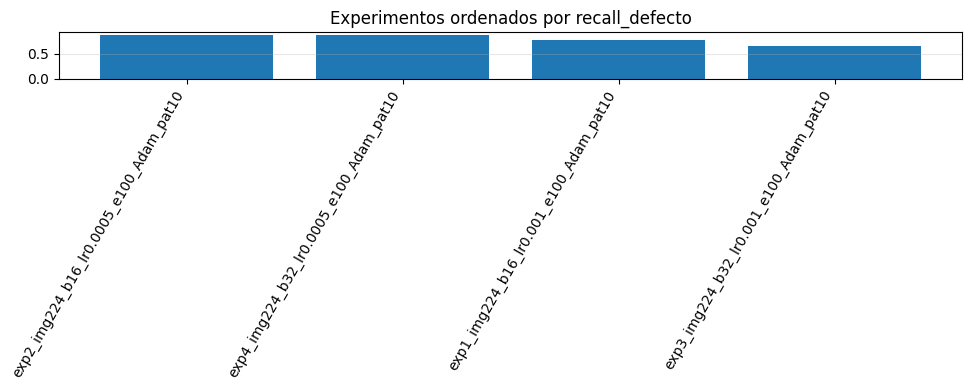

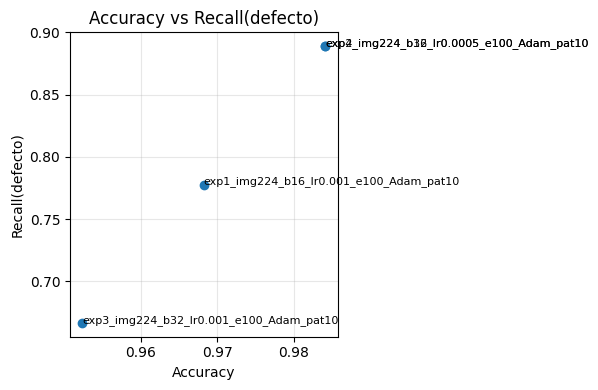

In [6]:
%matplotlib inline
plt.figure(figsize=(10,4))
df_sorted = df_grid.sort_values(SELECT_BY, ascending=False)
plt.bar(df_sorted["exp_name"], df_sorted[SELECT_BY])
plt.xticks(rotation=60, ha="right")
plt.title(f"Experimentos ordenados por {SELECT_BY}")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df_grid["accuracy"], df_grid["recall_defecto"])
for _, r in df_grid.iterrows():
    plt.text(r["accuracy"], r["recall_defecto"], r["exp_name"], fontsize=8)
plt.xlabel("Accuracy")
plt.ylabel("Recall(defecto)")
plt.title("Accuracy vs Recall(defecto)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Tres experimentos:

1️. exp3

Accuracy ≈ 0.955

Recall(defecto) ≈ 0.67
Malo: se le escapan muchos defectos.

2️. exp1

Accuracy ≈ 0.97

Recall(defecto) ≈ 0.78
Decente, pero aún pierde ~22% de defectos.

**3️. exp2**

Accuracy ≈ 0.985

Recall(defecto) ≈ 0.89
Claramente el mejor compromiso.

Se selecciona el modelo exp2 ya que maximiza el recall de la clase defecto, minimizando los falsos negativos, lo cual es crítico en un escenario de detección de defectos. Además, mantiene una accuracy global elevada, mostrando un buen equilibrio entre sensibilidad y rendimiento general.

In [ ]:
FINAL_MODEL_PATH = "runs_cls/exp2_img224_b32_lr0.0005_e100_Adam_pat10/weights/best.pt"

In [7]:
# Errores que se le escapan al mejor modelo:

df_errors = df_test[
    (df_test["true_class"] == "defecto") &
    (df_test["pred_class"] == "no_defecto")
].sort_values("confidence", ascending=False)

display(df_errors.head(10))

,image_path,image,true_class,pred_class,confidence
1,dataset_cls\test\defecto\kos08_Part2.jpg,kos08_Part2.jpg,defecto,no_defecto,0.999898
